### Copyright 2025 Edward Späth, Frankfurt University of Applied Sciences, FB2, Computer Science
### No liability or warranty; only for educational and non-commercial purposes
### See some basic hints for working with Jupyter notebooks in README.md

## Bin Packing Problem

### Imports

In [57]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import math
import numpy as np
import random

### Configuration

In [58]:
GRID_COLOR = "BLACK"
FIGURE_MARGIN = 0.1
# With this you can configure which kind of colors each item gets.
# For this, a color gradient (colormap) is used.
# Please see here to find all the available colormaps:
# https://matplotlib.org/stable/gallery/color/colormap_reference.html
# I recommend not picking one, which has white in its gradient.
BIN_PACKING_COLORMAP_NAME = "gist_rainbow"
BASE_GRID_WIDTH = 15
LEGEND_FONTSIZE = 16
LEGEND_LINE_SPACING = 1

### Class representing items

In [59]:
class Item:
    def __init__(self, size):
        self.size = size
        self._color = None

    def __repr__(self):
        return f"Item({self.size})"

    # Methods overwriting + operator
    def __add__(self, other):
        if isinstance(other, Item):
            return self.size + other.size
        else:
            return self.size + other

    # Overwriting + operator when Item is the right operand
    def __radd__(self, other):
        if other == 0:
            return self
        return self.__add__(other)


def create_items_bulk(*items):
    return list(map(lambda item: Item(item), items))

### Fixed size bin packing implementations

#### Best-fit

In [60]:
def fixed_size_bin_packing_best_fit(bin_capacity, amount_bins, elements):
    n = len(elements)
    bins = [[] for _ in range(amount_bins)]
    bins_in_use = []
    last_added_bin = -1
    for elem in elements:
        # search for bin in use where it fits best
        best_bin = -1
        best_remaining_capacity = bin_capacity
        for b in bins_in_use:
            remaining_capacity = bin_capacity - (sum(bins[b]) + elem.size)
            if remaining_capacity >= 0 and remaining_capacity < best_remaining_capacity:
                best_bin = b
                best_remaining_capacity = remaining_capacity
        # if not found: add new bin, if possible
        if best_bin == -1 and last_added_bin < amount_bins-1:
            last_added_bin += 1
            bins_in_use += [last_added_bin]
            # print("added", last_added_bin)
            # print("in use:", bins_in_use)
            remaining_capacity = bin_capacity - elem.size
            if remaining_capacity >= 0:
                best_bin = last_added_bin
                best_remaining_capacity = remaining_capacity
        # found? - if not: new bin - does it fit there?
        if best_bin != -1:
            bins[best_bin] += [elem]
            # is this bin full now?
            if best_remaining_capacity == 0:
                bins_in_use.remove(best_bin)
                # print("removed", best_bin)
                # print("in use:", bins_in_use)
        else:
            return False, bins
        # print(bins)
        # print(sum([elem for l in bins for elem in l]))
    return True, bins

#### First-fit

In [61]:
def fixed_size_bin_packing_first_fit(bin_capacity, amount_bins, elements):
    n = len(elements)
    bins = [[] for _ in range(amount_bins)]
    for elem in elements:
        i = 0
        found = False
        while i < amount_bins and not found:
            if sum(bins[i]) + elem.size <= bin_capacity:
                found = True
            else:
                i += 1
        if found:
            bins[i] += [elem]
        else:
            return found, bins
    return found, bins

#### Next-fit

In [62]:
def fixed_size_bin_packing_next_fit(bin_capacity, amount_bins, elements):
    n = len(elements)
    bins = [[] for _ in range(amount_bins)]
    current_bin = 0
    for elem in elements:
        if sum(bins[current_bin]) + elem.size <= bin_capacity:
            bins[current_bin] += [elem]
        else:
            current_bin += 1
            if current_bin < amount_bins and sum(bins[current_bin]) + elem.size <= bin_capacity:
                bins[current_bin] += [elem]
            else:
                return False, bins
    return True, bins

### Variable size bin packing implementations

#### Best-fit

In [63]:
def variable_size_bin_packing_best_fit(bin_capacities, elements):
    raise NotImplementedError
    return found, bins

#### First-fit

In [64]:
def variable_size_bin_packing_first_fit(bin_capacities, elements):
    raise NotImplementedError
    return found, bins

#### Next-fit

In [65]:
def variable_size_bin_packing_next_fit(bin_capacities, elements):
    raise NotImplementedError
    return found, bins

### Helper function for randomness

In [66]:
def get_random_capacities_and_items(min_bin_count, max_bin_count, min_bin_capacity, max_bin_capacity, min_item_count, max_item_count, min_item_size, max_item_size, variable_size=False):
    if min_bin_count > max_bin_count:
        print("Minimum and maximum bin count were implicitly swapped.")
        min_bin_count, max_bin_count = max_bin_count, min_bin_count
    if min_bin_capacity > max_bin_capacity:
        print("Minimum and maximum bin capacity were implicitly swapped.")
        min_bin_capacity, max_bin_capacity = max_bin_capacity, min_bin_capacity
    if min_item_count > max_item_count:
        print("Minimum and maximum item count were implicitly swapped.")
        min_item_count, max_item_count = max_item_count, min_item_count
    if min_item_size > max_item_size:
        print("Minimum and maximum item size were implicitly swapped.")
        min_item_size, max_item_size = max_item_size, min_item_size
    amount_bins = random.randrange(min_bin_count, max_bin_count)
    bin_capacities = []
    for _ in range(amount_bins if variable_size else 1):
        bin_capacity = round(
            np.random.random() * (max_bin_capacity - min_bin_capacity) + min_bin_capacity)
        bin_capacities.append(bin_capacity)
    amount_items = random.randrange(min_item_count, max_item_count)
    items = []
    for _ in range(amount_items):
        size = round(np.random.random() *
                     (max_item_size - min_item_size) + min_item_size)
        items.append(size)
    if variable_size:
        return bin_capacities, items
    else:
        # If variable size bin packing were to be implemented, return the capacities by themselves
        # I.e., use the above return statement in both scenarios
        return bin_capacities[0], amount_bins, items

### Visualization

In [67]:
def determine_start_position_and_direction(amount_rows, amount_columns, amount_items):
    start_from_left = amount_rows % 2 == 1 or amount_rows * \
        amount_columns == amount_items
    if start_from_left:
        next_cell = (0, 0)
        horizontal_direction = 1  # 1=go right, -1=go left
    else:
        next_cell = (amount_columns, 0)
        horizontal_direction = -1  # 1=go right, -1=go left
    return next_cell, horizontal_direction


def draw_grid_around_cell(x, y, ax, width=1, height=1, color=GRID_COLOR):
    ax.hlines([y], x, x+width, colors=color)
    ax.hlines([y+height], x, x+width, colors=color)
    ax.vlines([x], y, y+height, colors=color)
    ax.vlines([x+width], y, y+height, colors=color)


def insert_cell(next_cell, horizontal_direction, max_x, item, ax):
    x, y = next_cell
    x_offset = -0.5 + horizontal_direction/2
    ax.add_patch(plt.Rectangle((x + x_offset, y),
                 1, 1, facecolor=item._color))
    next_cell, horizontal_direction = get_next_position(
        next_cell, horizontal_direction, max_x)
    return next_cell, horizontal_direction


def get_next_position(next_cell, horizontal_direction, max_x):
    next_x, next_y = next_cell
    potential_next_x = next_x + horizontal_direction
    next_x = potential_next_x
    if potential_next_x >= max_x:
        next_y += 1
        next_x = max_x
        horizontal_direction = -1
    if potential_next_x <= 0:
        next_y += 1
        next_x = 0
        horizontal_direction = 1
    next_cell = (next_x, next_y)
    return next_cell, horizontal_direction


def visualize_container(label, capacity, items, ax, max_bin_count, is_leftover_bin=False):
    # No capacity, therefore nothing to visualize
    if capacity <= 0:
        return
    # Determine how many rows and columns are required
    amount_columns = math.ceil(math.sqrt(capacity))
    amount_rows = math.ceil(capacity / amount_columns)
    # Determine size of figure and define grid boundaries
    grid_height_to_width_ratio = amount_rows/amount_columns
    # ax.figure.set_size_inches(BASE_GRID_WIDTH, BASE_GRID_WIDTH * grid_height_to_width_ratio)
    ax.figure.set_size_inches(
        BASE_GRID_WIDTH, BASE_GRID_WIDTH * grid_height_to_width_ratio)
    ax.axis([0 - FIGURE_MARGIN, amount_columns + FIGURE_MARGIN, 0 -
            FIGURE_MARGIN, amount_rows + FIGURE_MARGIN])  # xmin, xmax, ymin, ymax
    ax.apply_aspect()
    # Make sure that X and Y axes are scaled equally
    ax.set_aspect("equal", adjustable="box")
    for i in range(capacity):
        column = i % amount_columns
        row = math.floor(i / amount_columns)
        draw_grid_around_cell(column, row, ax)
    # Determine whether to start filling from right or left
    # to make sure, that the empty space will be in the top right corner
    next_cell, horizontal_direction = determine_start_position_and_direction(
        amount_rows, amount_columns, len(items))
    # Iterate over all items and place them
    for item in items:
        # Place one cell for each unit of size into the grid
        for cell in range(item.size):
            next_cell, horizontal_direction = insert_cell(
                next_cell, horizontal_direction, amount_columns, item, ax)
    total_size = sum(map(lambda item: item.size, items))
    if is_leftover_bin:
        ax.set_title(label + f"\n{capacity}", fontsize=18)
    else:
        ax.set_title(
            label + f"\ncapacity: {capacity}\nused: {total_size}", fontsize=18)


def bin_packing(bin_capacities, elements, approach, fixed_size=True):
    if approach == "BEST":
        if fixed_size:
            return fixed_size_bin_packing_best_fit(bin_capacities[0], len(bin_capacities), elements)
        else:
            return variable_size_bin_packing_best_fit(bin_capacities, elements)
    elif approach == "FIRST":
        if fixed_size:
            return fixed_size_bin_packing_first_fit(bin_capacities[0], len(bin_capacities), elements)
        else:
            return variable_size_bin_packing_first_fit(bin_capacities, elements)
    elif approach == "NEXT":
        if fixed_size:
            return fixed_size_bin_packing_next_fit(bin_capacities[0], len(bin_capacities), elements)
        else:
            return variable_size_bin_packing_next_fit(bin_capacities, elements)
    else:
        print(r'Please select "BEST", "FIRST", or "NEXT" as approach.')
        return None


def create_overview(approach, could_not_place_size, amount_bins, ax):
    ax.figure.set_size_inches(BASE_GRID_WIDTH, BASE_GRID_WIDTH)
    if approach == "BEST":
        approach_text = "Best-fit bin packing"
    elif approach == "FIRST":
        approach_text = "First-fit bin packing"
    elif approach == "NEXT":
        approach_text = "Next-fit bin packing"
    overview_text = approach_text
    overview_text += "\n" + \
        ("(Successful)" if could_not_place_size == 0 else "(Not successful)")
    overview_text += "\n" + f"bins used: {amount_bins}"
    if could_not_place_size > 0:
        overview_text += "\n" + f"leftover: {could_not_place_size}"
    ax.text(0.5, 0.5, overview_text, ha="center", va="center", fontsize=18)

# If fixed size bin packing is implemented,
# then use this function as starting point instead of wrapper (below).
def _visualize_bin_packing_delegation(capacities, items, fixed_size=True):
    items = create_items_bulk(*items)
    # If doing fixed size bin packing, then assume capacity of first bin for all bins
    if fixed_size:
        capacities = [capacities[0] for _ in range(len(capacities))]
    colors = mpl.colormaps[BIN_PACKING_COLORMAP_NAME](
        np.linspace(0, 1, len(items)))
    for item, color in zip(items, colors):
        item._color = color
    approaches = ["BEST", "FIRST", "NEXT"]
    results = []
    for approach in approaches:
        results.append(bin_packing(
            capacities, items, approach, fixed_size=True))
    max_bin_count = 0
    for is_possible, used_bins in results:
        bin_count = len(used_bins) + (1 if not is_possible else 0)
        if bin_count > max_bin_count:
            max_bin_count = bin_count
    fig, axs = plt.subplots(3, max_bin_count + 1)
    fig.set_size_inches(15, 20)
    for i, (is_possible, used_bins) in enumerate(results):
        approach = approaches[i]
        axs_row = axs[i]
        for ax in axs_row:
            ax.axis("off")
        if not is_possible:
            used_items = [item for item in used_bins for item in item]
            leftover_items = [item for item in items if item not in used_items]
        could_not_place_size = 0 if is_possible else sum(
            map(lambda item: item.size, leftover_items))
        create_overview(approach, could_not_place_size,
                        len(used_bins), axs_row[0])
        for i, used_bin in enumerate(used_bins):
            ax = axs_row[1:][i]
            visualize_container(
                f"Bin {i+1}", capacities[i], used_bin, ax, max_bin_count)
        if not is_possible:
            visualize_container(f"Leftover", sum(map(lambda item: item.size, leftover_items)),
                                leftover_items, axs_row[-1], max_bin_count, is_leftover_bin=True)
    plt.tight_layout()
    plt.show()

# If fixed size bin packing is implemented,
# then remove this wrapper and instead use (rename) the function above as starting point.
def visualize_bin_packing(bin_capacity, bin_count, items):
    _visualize_bin_packing_delegation(
        [bin_capacity] * bin_count, items, fixed_size=True)

### Example

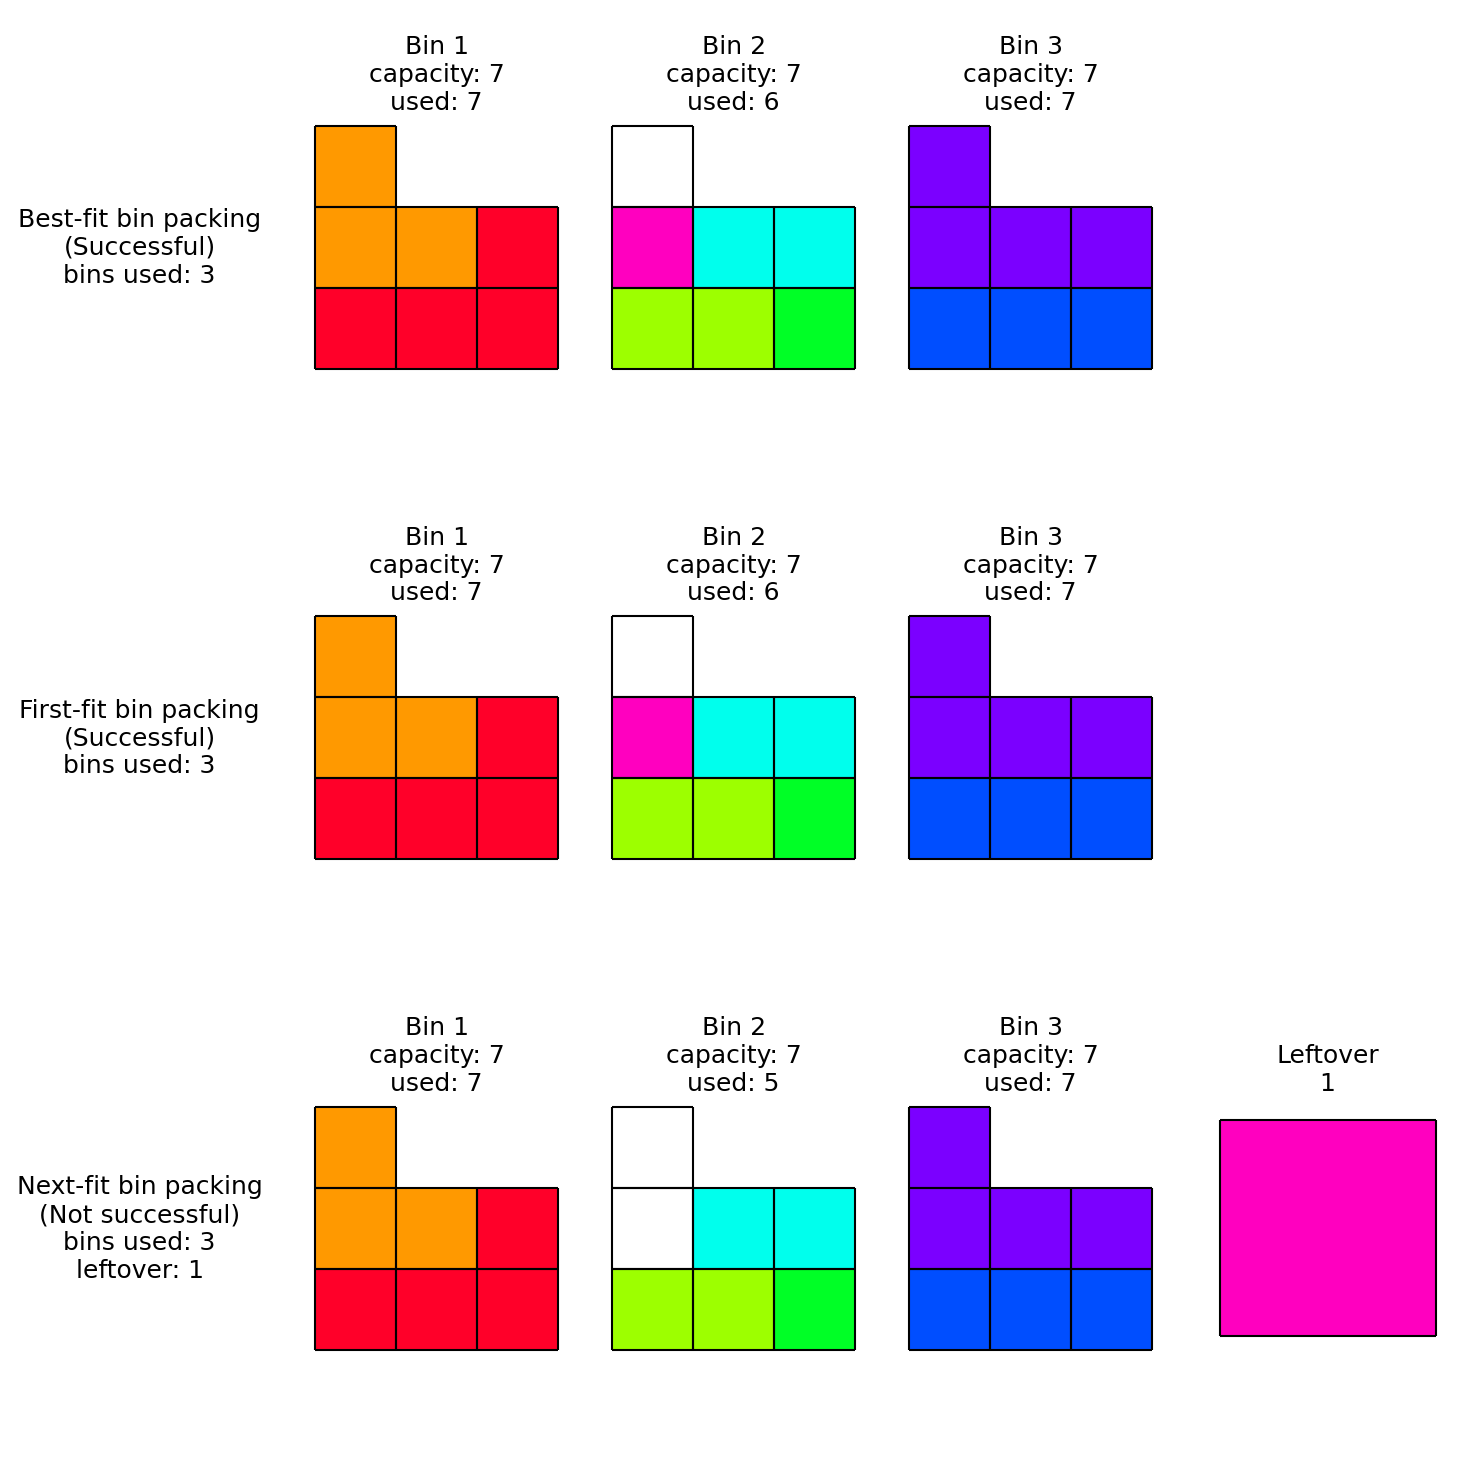

In [68]:
capacity = 7
bin_count = 3
items = [4, 3, 2, 1, 2, 3, 4, 1]

visualize_bin_packing(capacity, bin_count, items)

### Example with random bins and items

capacity = 9
amount_bins = 5
items = [8, 4, 3, 4, 2]


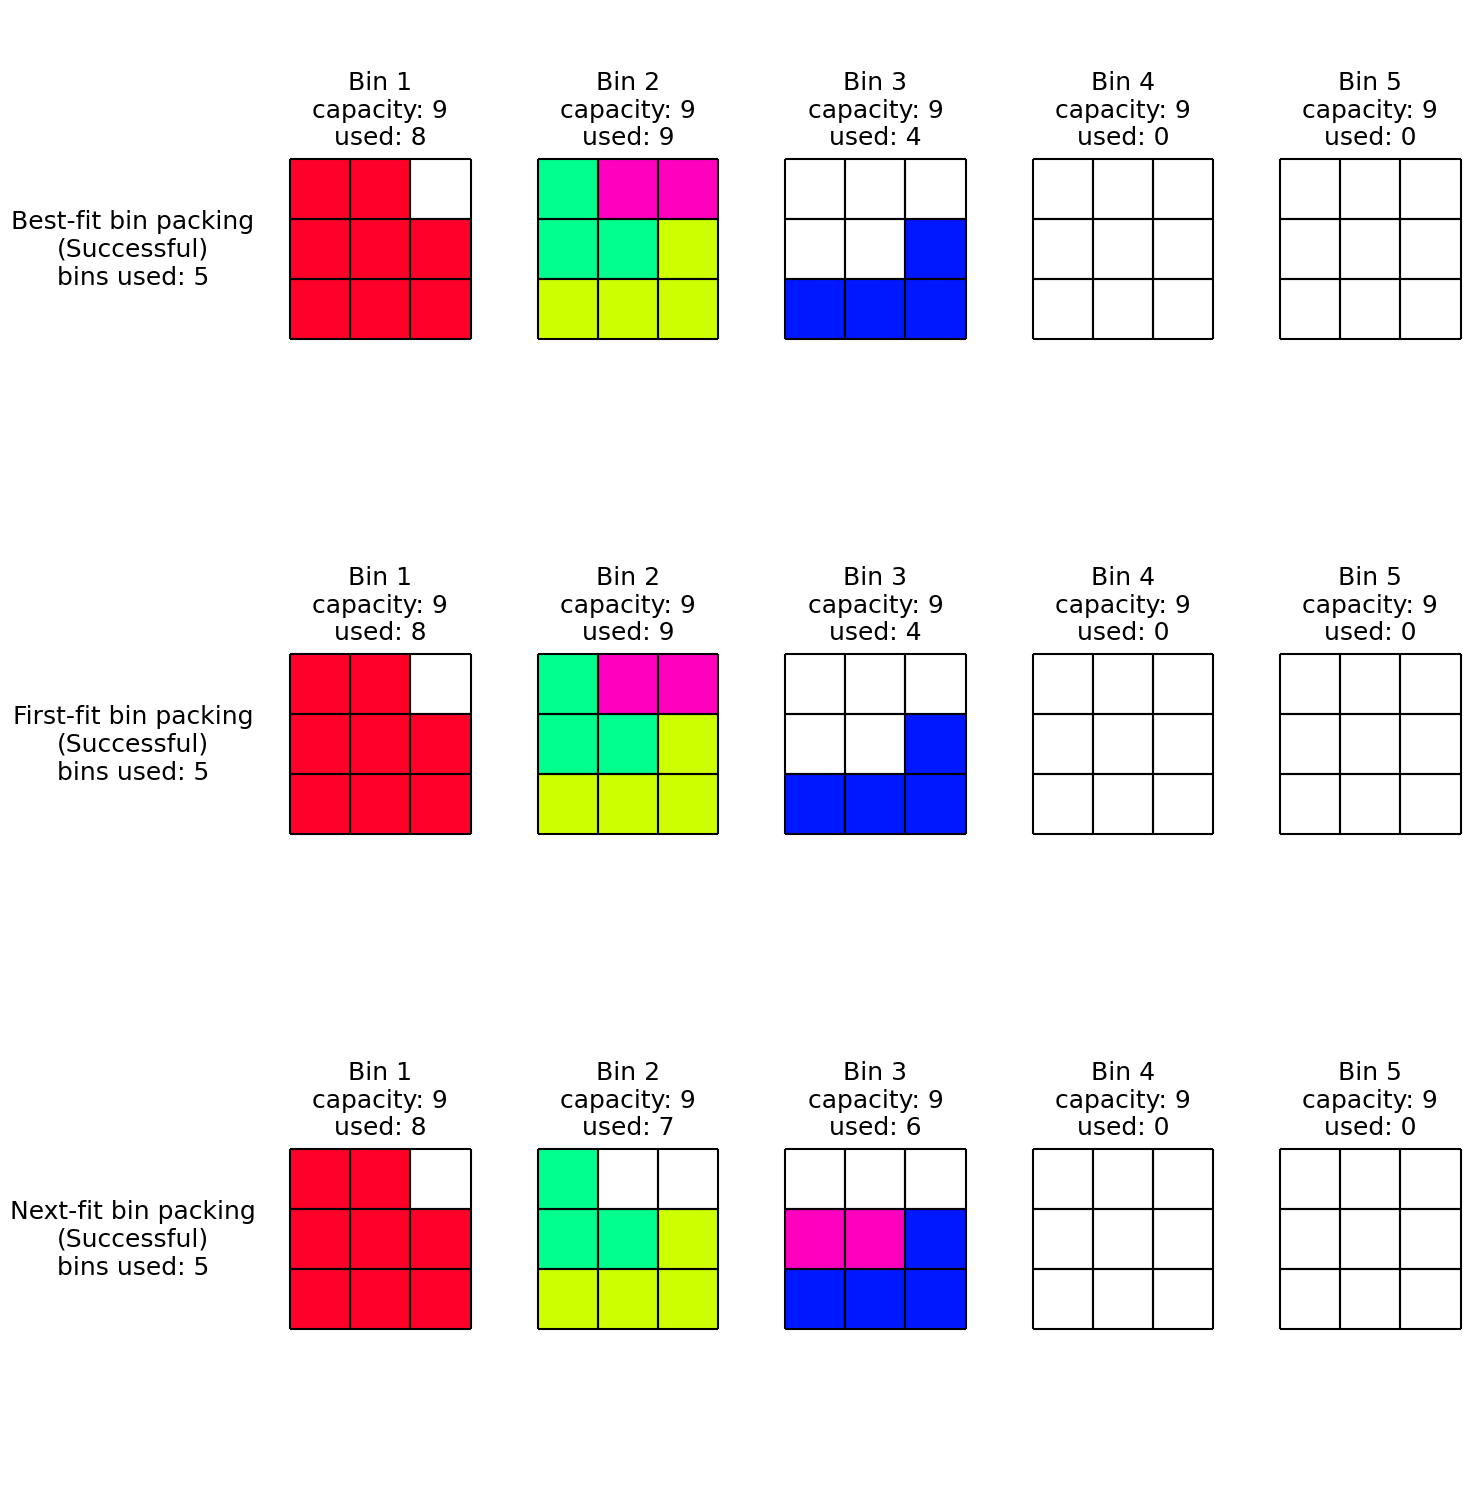

capacity = 17
amount_bins = 3
items = [2, 6, 1, 2]


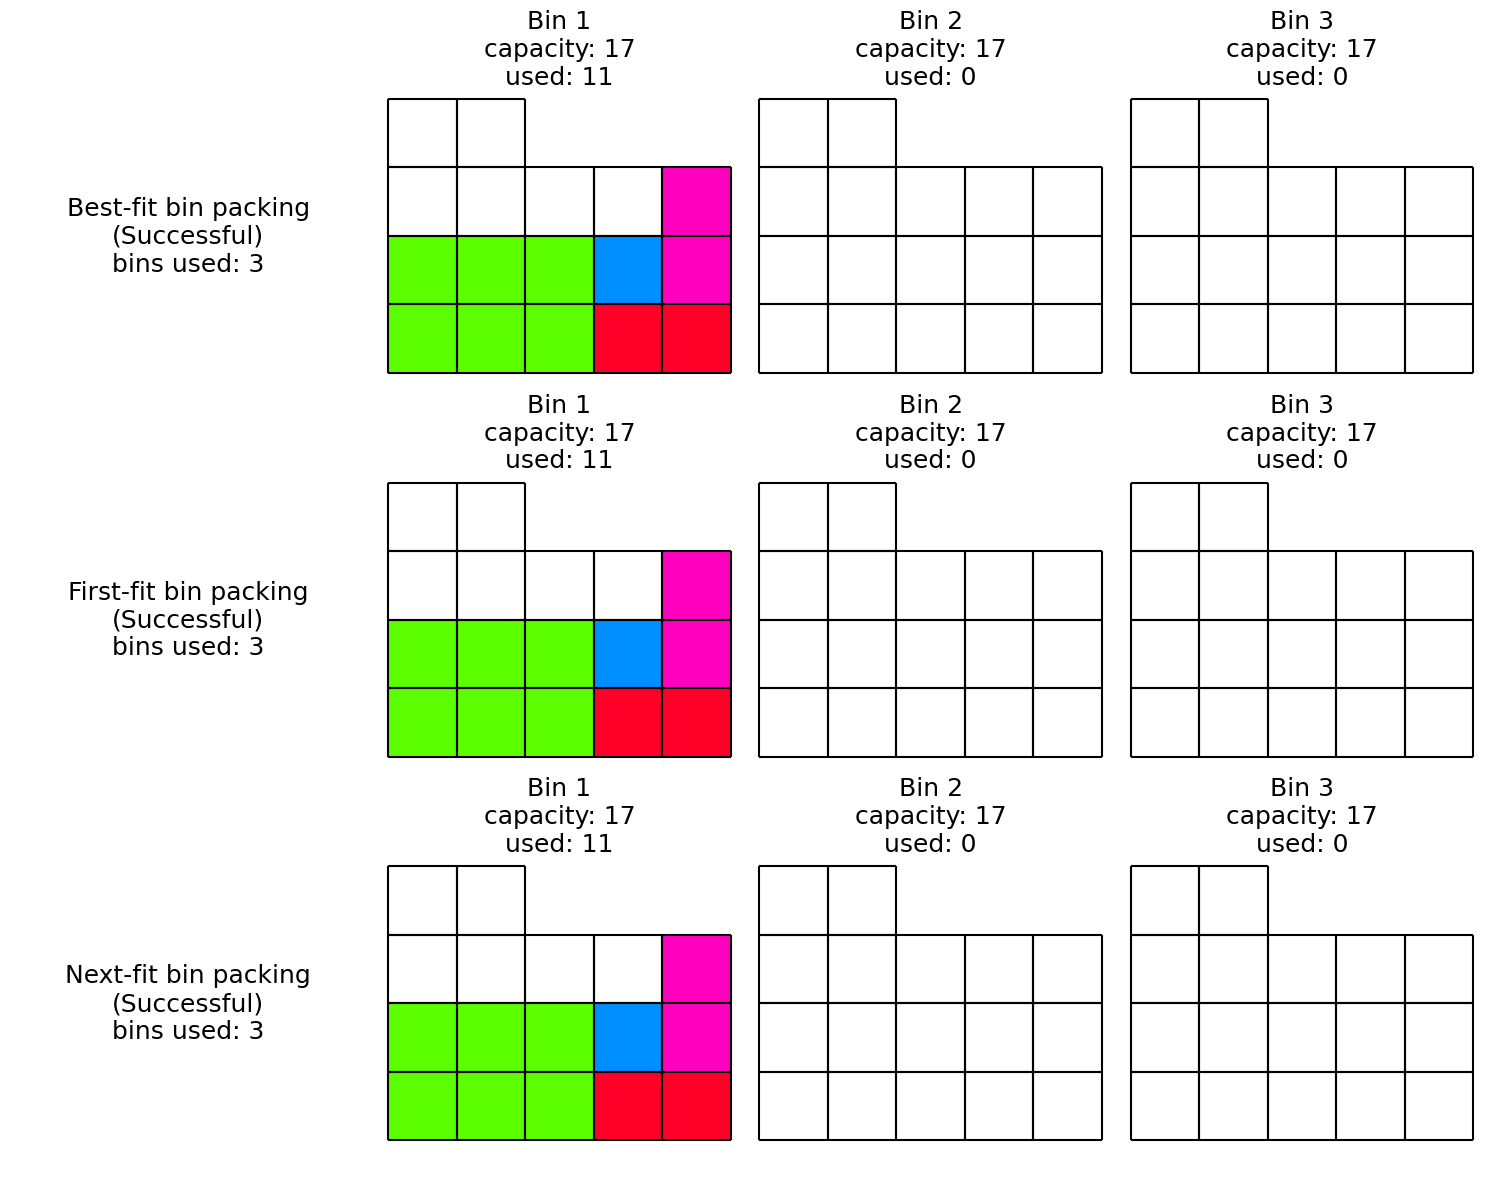

In [69]:
AMOUNT_ITERATIONS = 2
ALLOW_FRACTIONS = True

BINS_COUNT_MIN = 3
BINS_COUNT_MAX = 10
BINS_CAPACITY_MIN = 5
BINS_CAPACITY_MAX = 20
ITEM_COUNT_MIN = 3
ITEM_COUNT_MAX = 10
ITEM_SIZE_MIN = 1
ITEM_SIZE_MAX = 10

for _ in range(AMOUNT_ITERATIONS):
    capacity, amount_bins, items = get_random_capacities_and_items(
        BINS_COUNT_MIN, BINS_COUNT_MAX, BINS_CAPACITY_MIN, BINS_CAPACITY_MAX, ITEM_COUNT_MIN, ITEM_COUNT_MAX, ITEM_SIZE_MIN, ITEM_SIZE_MAX)
    print("capacity =", capacity)
    print("amount_bins =", amount_bins)
    print("items =", items)
    visualize_bin_packing(capacity, amount_bins, items)

### Your tests go here...

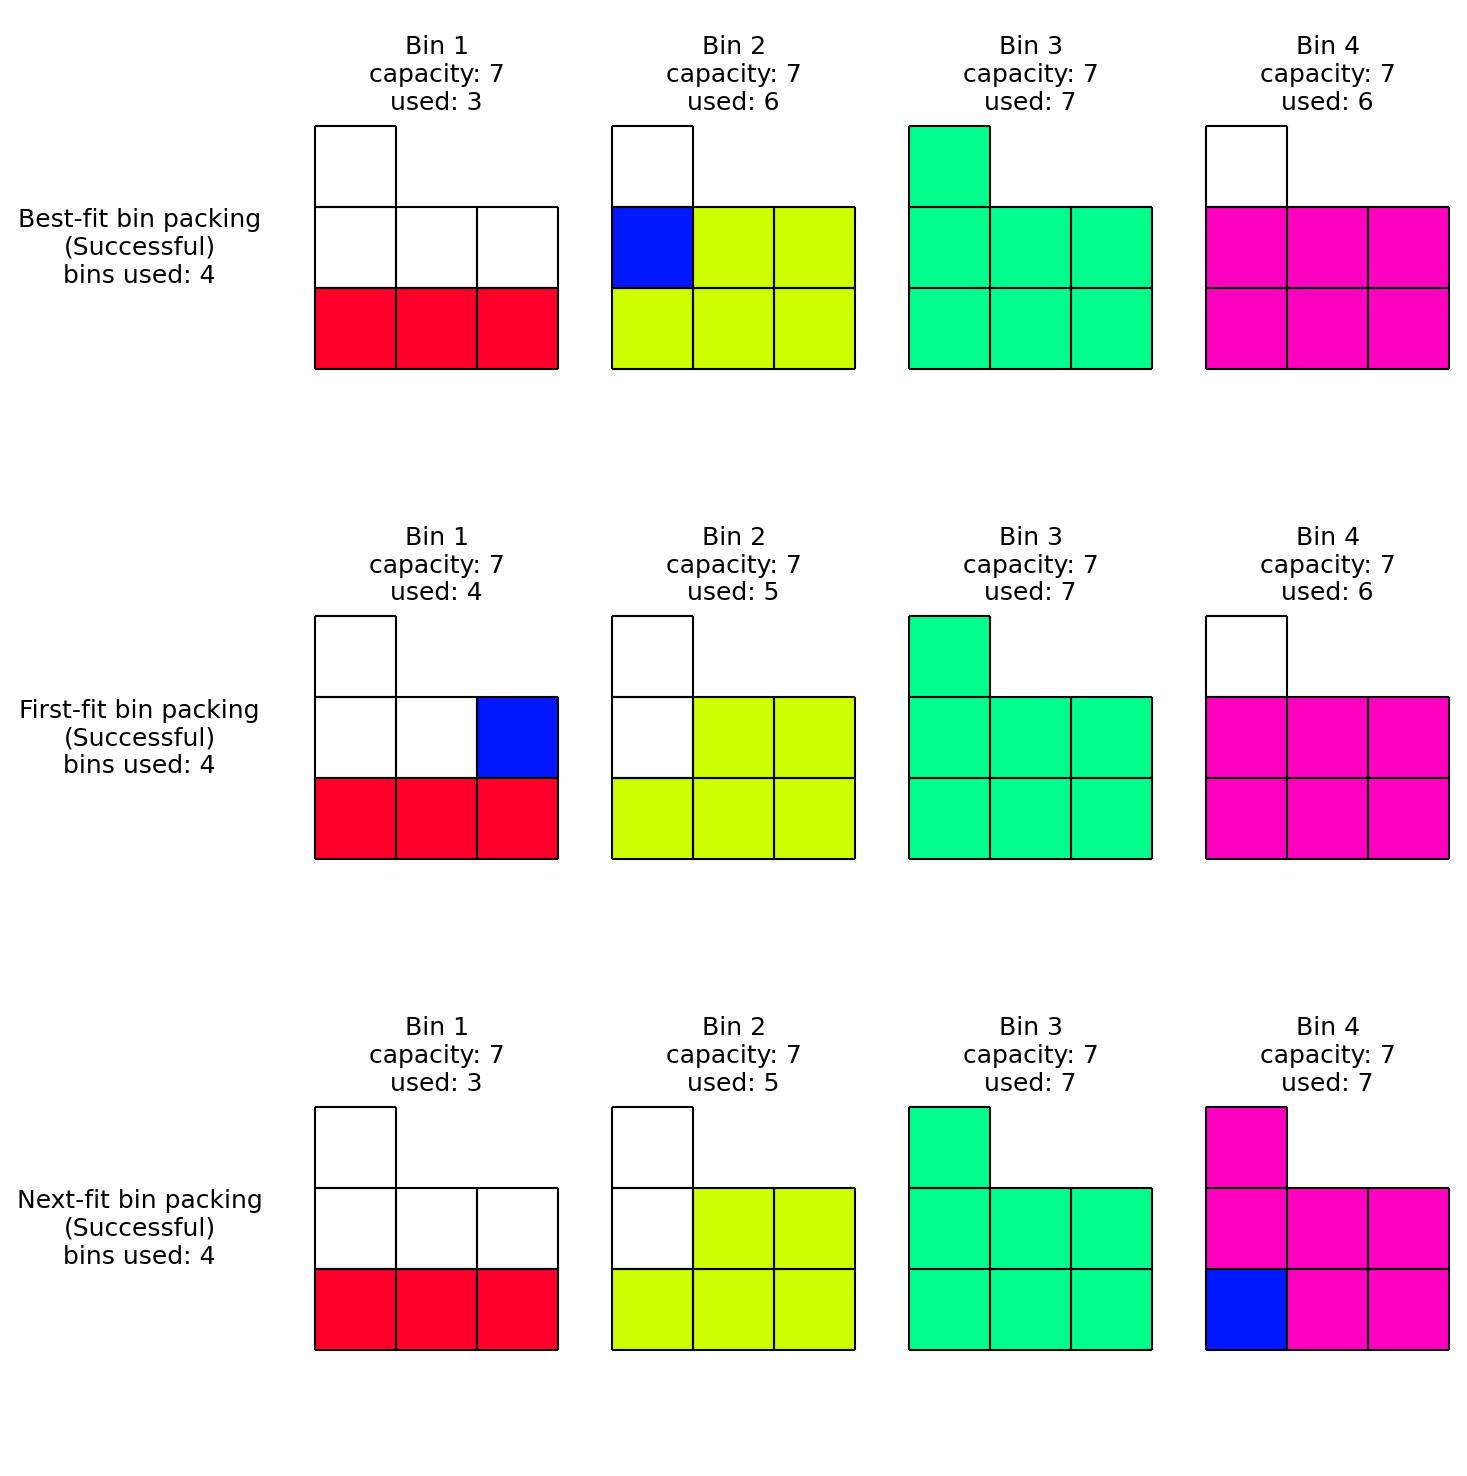

In [70]:
capacity = 7
bin_count = 4
items = [3, 5, 7, 1, 6]

visualize_bin_packing(capacity, bin_count, items)